In [2]:
!pip install hume

zsh:1: /Users/Parzon/opt/anaconda3/bin/pip: bad interpreter: /Users/macbook/opt/anaconda3/bin/python: no such file or directory
  Using cached hume-0.7.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
Using cached hume-0.7.2-py3-none-any.whl (290 kB)
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
Using cached eval_type_backport-0.2.0-py3-none-any.whl (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.2 MB/s eta 0:00:00a 0:00:01


In [2]:
%pip install matplotlib
%pip install numpy
%pip install pandas



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.5 MB/s eta 0:00:00a 0:00:01m
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 8.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225303859535_2.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225258875081_1.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225353864089_12.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225328865368_7.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225427012527_19.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225318861031_5.wav
Pr

ERROR:__main__:Unexpected response type: <class 'hume.expression_measurement.stream.types.stream_error_message.StreamErrorMessage'>. Response: error='Audio too long. 5016ms is over the limit of 5000ms.' code='E0203' payload_id='d5853c08-aaa1-4fd4-a5b6-42135862d59d' job_details=None


Failed to analyze audio for audio_20241021225445851836_23.wav.
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225417948711_17.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225333856507_8.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225413420039_16.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225348863734_11.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio/audio_20241021225403864570_14.wav
Processing file: /Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyG

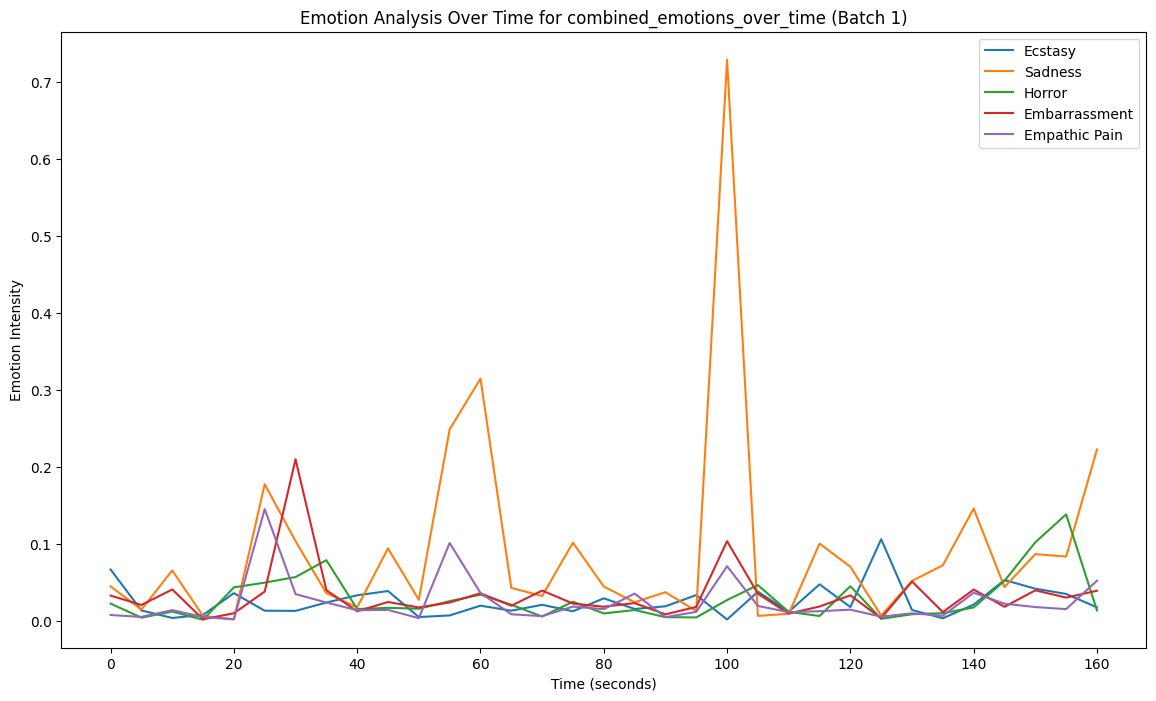

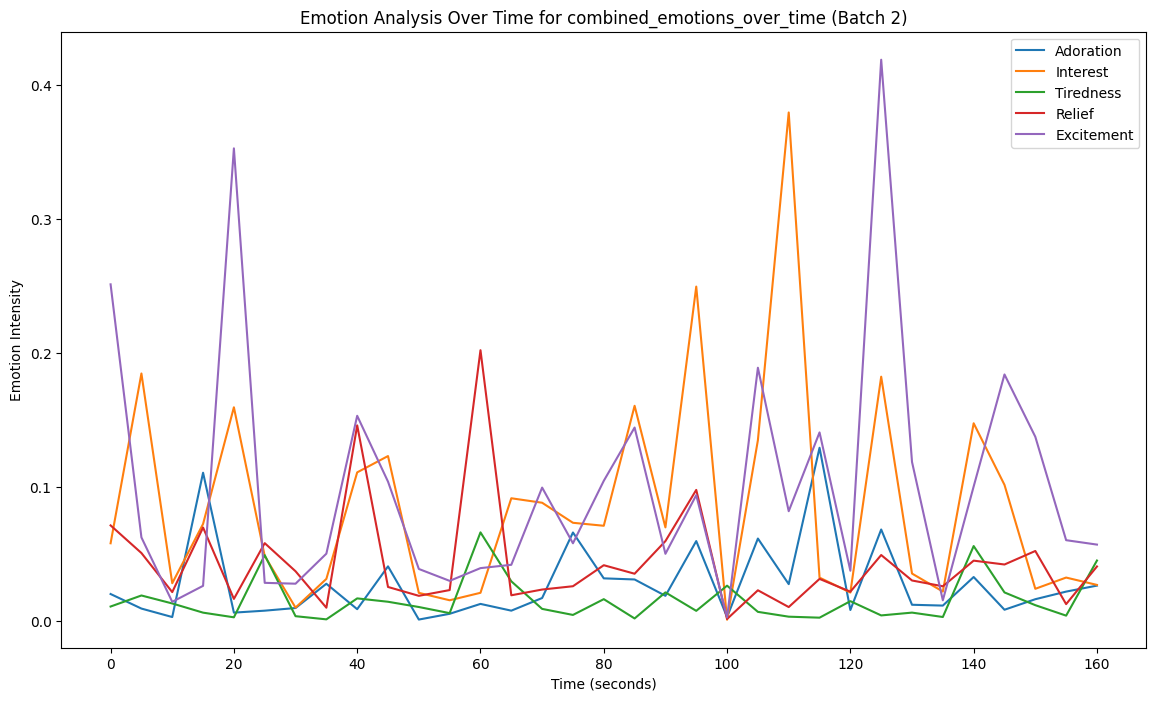

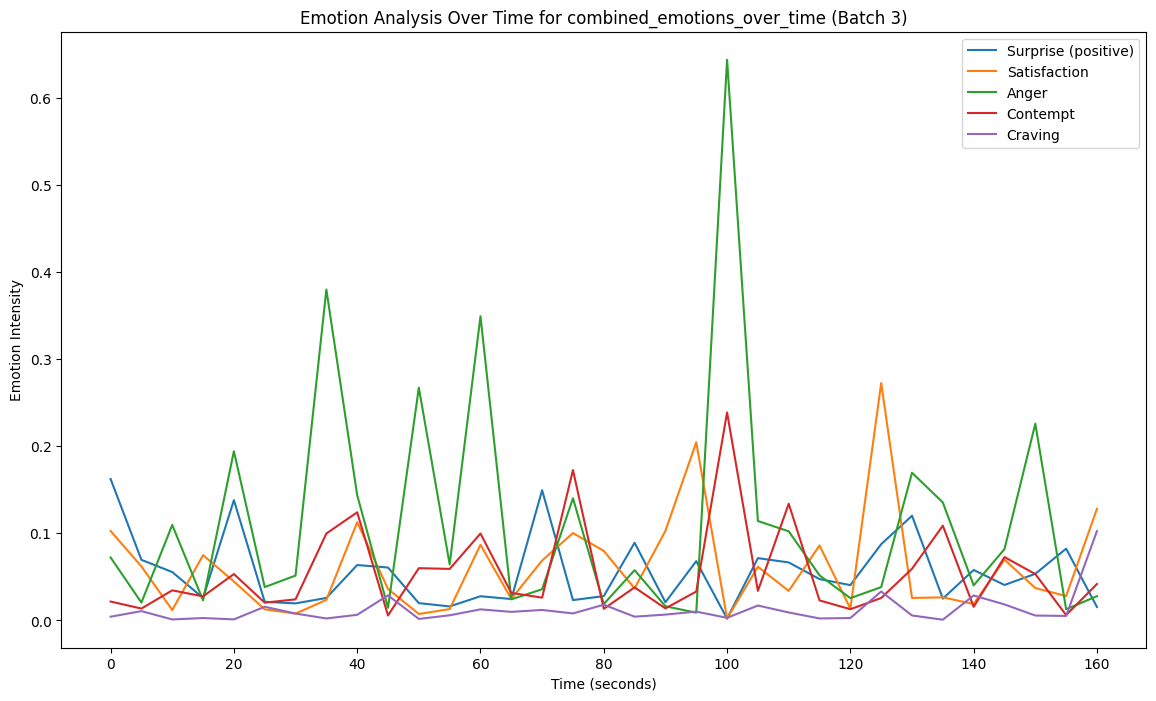

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-147' coro=<process_audio_folder() done, defined at /var/folders/gm/g5ygsmvs5818mzw0tptl_zxw0000gn/T/ipykernel_49486/2902337777.py:94> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Users/Parzon/anaconda3/envs/heygenexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gm/g5ygsmvs5818mzw0tptl_zxw0000gn/T/ipykernel_49486/2902337777.py", line 115, in <module>
    loop.run_until_complete(process_audio_folder(wav_folder_path))
  File "/Users/Parzon/anaconda3/envs/heygenexec/lib/python3.9/site-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/Users/Parzon/anaconda3/envs/heygenexec/lib/python3.9/site-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/Users/Parzon/anaconda3/envs/heygenexec/lib/python3.9/asyncio/

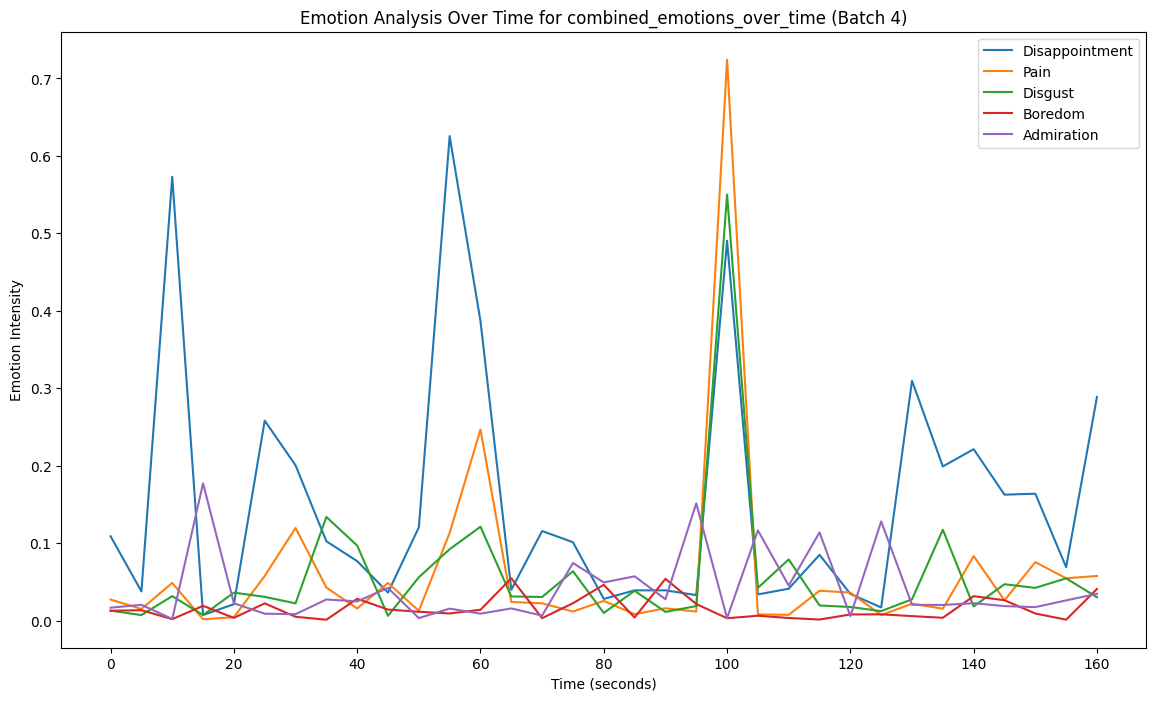

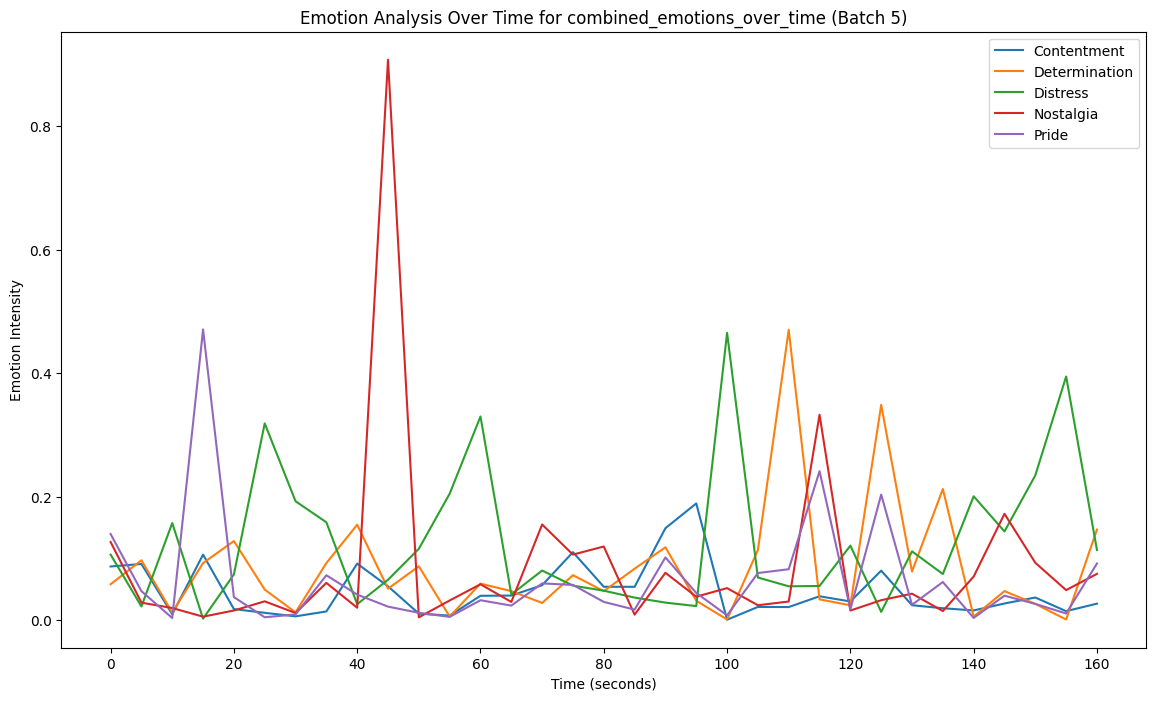

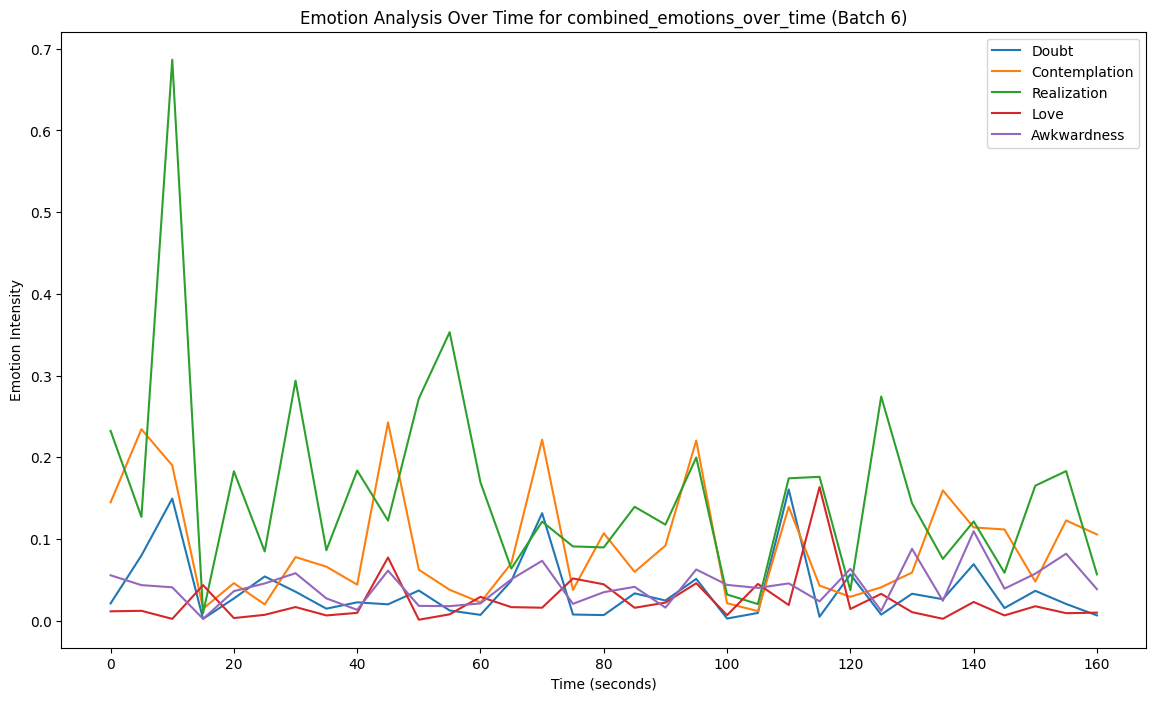

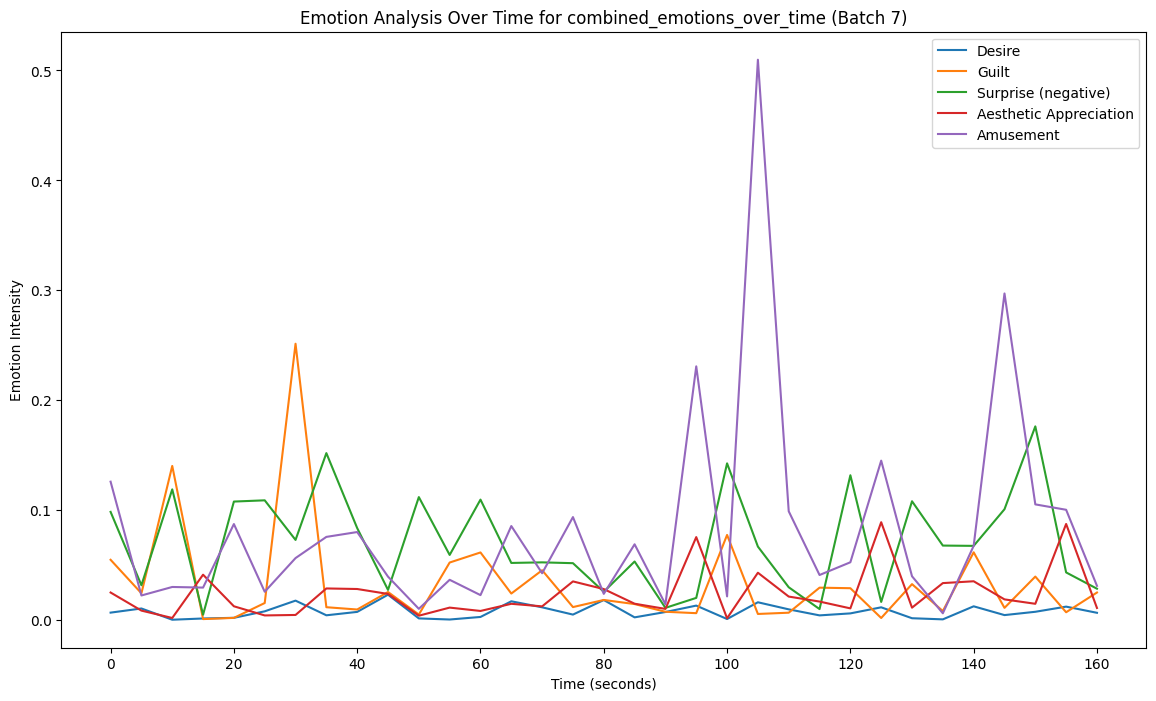

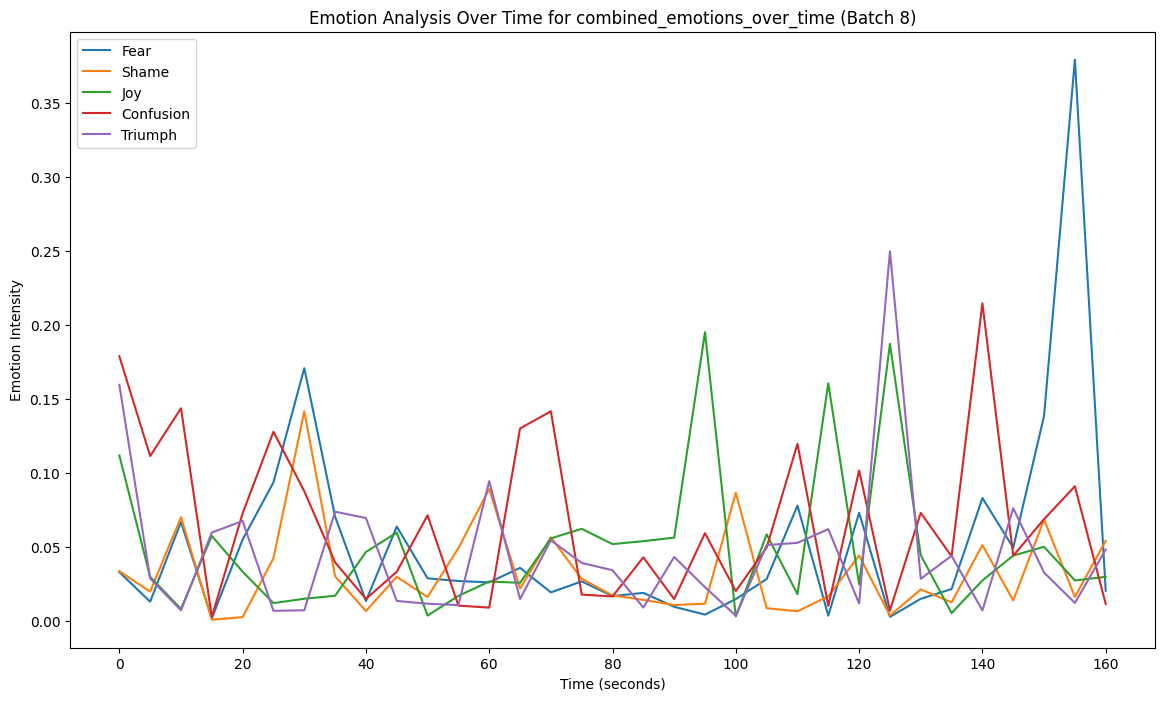

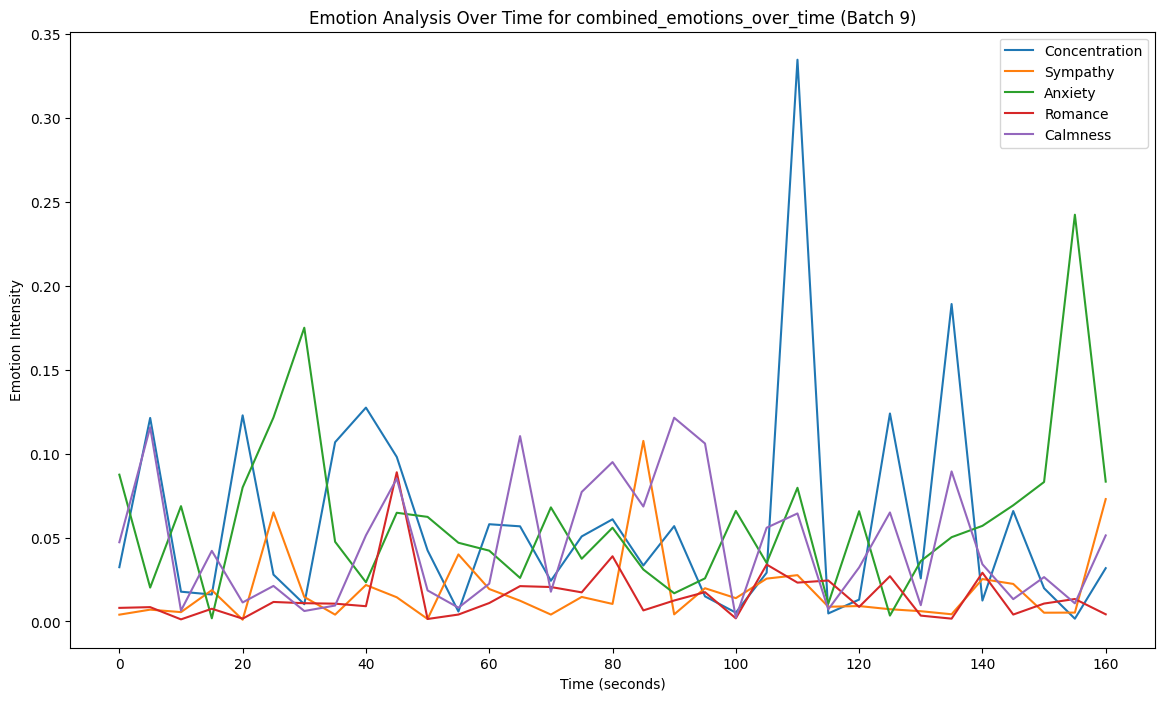

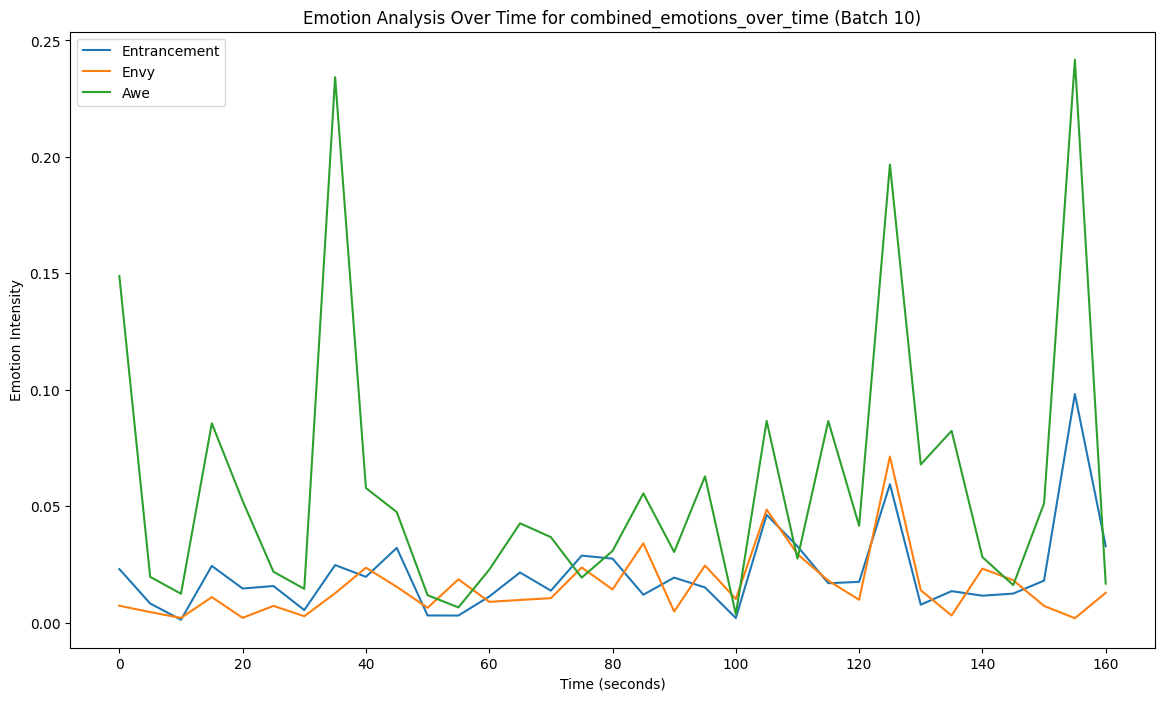

In [25]:
import os
import asyncio
import json
import logging
import matplotlib.pyplot as plt
from hume.client import AsyncHumeClient
from hume.expression_measurement.stream import Config
from hume.expression_measurement.stream.socket_client import StreamConnectOptions
import nest_asyncio

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up your API key
API_KEY = "sQp9AtmP52EQ5kD1AG9aQxYfZgrkPvwrOKGZZAxaZAqbynvv"

# Perform Hume emotion analysis on a given audio file
async def analyze_audio(file_path):
    client = AsyncHumeClient(api_key=API_KEY)
    model_config = Config(prosody={})
    stream_options = StreamConnectOptions(config=model_config)

    retries = 3
    for attempt in range(retries):
        try:
            async with client.expression_measurement.stream.connect(options=stream_options) as socket:
                result = await socket.send_file(file_path)
                if hasattr(result, "prosody"):
                    return result.prosody.predictions
                else:
                    logger.error(f"Unexpected response type: {type(result)}. Response: {result}")
                    return None
        except Exception as e:
            logger.error(f"Error during audio analysis (attempt {attempt + 1}): {e}")
            if attempt < retries - 1:
                await asyncio.sleep(2 ** attempt)
            else:
                logger.error("Exceeded maximum retries for audio analysis.")
                return None

# Plot emotional analysis over time for all emotions in groups of 5
def plot_emotions_over_time(prosody_data, file_name, save_json=True):
    if not prosody_data:
        print(f"No prosody data to plot for {file_name}.")
        return

    # Save prosody data as JSON
    if save_json:
        with open(f"{file_name}_emotions.json", "w") as json_file:
            json.dump([{
                "time": {
                    "begin": prediction.time.begin,
                    "end": prediction.time.end
                },
                "emotions": [
                    {
                        "name": emotion.name,
                        "score": emotion.score
                    } for emotion in prediction.emotions
                ]
            } for prediction in prosody_data], json_file, indent=4)

    # Extract all emotion names
    all_emotions = set()
    for prediction in prosody_data:
        for emotion in prediction.emotions:
            all_emotions.add(emotion.name)
    all_emotions = list(all_emotions)

    # Consolidate time across all files
    time_points = []
    for idx, prediction in enumerate(prosody_data):
        time_points.append(idx * 5)  # Assuming each prediction covers a 5-second span

    # Plot emotions in groups of 5
    batch_size = 5
    batch_counter = 1
    for i in range(0, len(all_emotions), batch_size):
        selected_emotions = all_emotions[i:i + batch_size]
        emotion_values = {emotion: [0] * len(time_points) for emotion in selected_emotions}

        for idx, prediction in enumerate(prosody_data):
            for emotion in prediction.emotions:
                if emotion.name in selected_emotions:
                    emotion_values[emotion.name][idx] = emotion.score

        plt.figure(figsize=(14, 8))
        for emotion in selected_emotions:
            plt.plot(time_points, emotion_values[emotion], label=emotion)

        plt.xlabel("Time (seconds)")
        plt.ylabel("Emotion Intensity")
        plt.title(f"Emotion Analysis Over Time for {file_name} (Batch {batch_counter})")
        plt.legend()
        plt.savefig(f"{file_name}_batch_{batch_counter}.png")
        plt.show()
        plt.close()

        batch_counter += 1

# Main function to process all WAV files in a folder and save plots and JSONs
async def process_audio_folder(folder_path):
    wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    if not wav_files:
        print("No WAV files found in the specified folder.")
        return

    combined_prosody_data = []
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        print(f"Processing file: {file_path}")
        analysis_result = await analyze_audio(file_path)
        if analysis_result:
            combined_prosody_data.extend(analysis_result)
        else:
            print(f"Failed to analyze audio for {wav_file}.")

    if combined_prosody_data:
        plot_emotions_over_time(combined_prosody_data, "combined_emotions_over_time")

if __name__ == "__main__":
    # Change this path to the appropriate folder containing your WAV files
    wav_folder_path = "/Users/Parzon/Downloads/Artificial_Consciousness/InteractiveAvatarNextJSDemo-main/HeyGenPersonalised/uploaded_audio"
    nest_asyncio.apply()  # To prevent event loop running error in Jupyter-like environments

    loop = asyncio.get_event_loop()
    loop.run_until_complete(process_audio_folder(wav_folder_path))


In [1]:
import os
secret_key = os.urandom(24)
print(secret_key)


b'\x9c!hV\xfa\xea\xba\xcf\x1a\x84s\xa0A\xa3\xbeodw\xd2\x92P6\xdb\xd9'
